<a href="https://colab.research.google.com/github/DenyT17/Football_Object_Detection/blob/main/football_field_lines_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/meng-tsai/soccer-line-detection.git

Cloning into 'soccer-line-detection'...
remote: Enumerating objects: 926, done.
remote: Counting objects: 100% (926/926), done.
remote: Compressing objects: 100% (908/908), done.
remote: Total 926 (delta 13), reused 923 (delta 12), pack-reused 0
Receiving objects: 100% (926/926), 19.43 MiB | 16.95 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [7]:
!pip install import_ipynb
!pip install dominate
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import matplotlib.patches as patches
import os
import torch
import torchvision.transforms as transforms
import skimage

%cd /content/soccer-line-detection
from options.generate_options import GenerateOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
from util.visualizer import Visualizer
from util.util import save_image
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/soccer-line-detection


In [8]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')
ssd_model = ssd_model.to('cuda')
ssd_model.eval()

/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [65]:
def plot_image(image: np.ndarray, size: int = 12) -> None:
  plt.figure(figsize=(size, size))
  plt.imshow(image[...,::-1])
  plt.show()

In [66]:
def SSD(tensor, ssd_model):
    with torch.no_grad():
        detections = ssd_model(tensor)
    results = utils.decode_results(detections)
    best_results = [utils.pick_best(results, 0.40) for results in results]
    classes_to_labels = utils.get_coco_object_dictionary()
    person_counter = 0
    for image_idx in range(len(best_results)):
#         fig, ax = plt.subplots(1, figsize=(7,7))
        # Show original, denormalized image...
        image = tensor[image_idx] / 2 + 0.5
#         ax.imshow(image)
        # ...with detections
        bboxes, classes, confidences = best_results[image_idx]
        for idx in range(len(bboxes)):
#             left, bot, right, top = bboxes[idx]
#             x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
#             rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
#             ax.add_patch(rect)
#             ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
            if classes[idx] == 1:
                person_counter += 1
#         plt.show()
    return person_counter

In [67]:
def load_PIL_image(PIL_image):
    """Code from Loading_Pretrained_Models.ipynb - a Caffe2 tutorial"""
    img = skimage.img_as_float(PIL_image)
    if len(img.shape) == 2:
        img = np.array([img, img, img]).swapaxes(0,2)
    return img

def prepare_input_from_PIL(PIL_img):
    img = load_PIL_image(PIL_img)
    img = utils.rescale(img, 300, 300)
    img = utils.crop_center(img, 300, 300)
    img = utils.normalize(img)

    return img

In [68]:
def is_longview(img, ssd_model) -> bool:
    img = cv2.resize(img, (455, 256))
    #cv2.imshow("input", img)
    height, width, _ = img.shape
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    thres = 0.75
    h_lower = 30
    h_upper = 90
    field_mask = cv2.inRange(hsv,(h_lower, 0, 50),(h_upper, 255,255))
    persons = 5
    is_field = (np.sum(field_mask)/(width*height)/255 > thres)
#     if is_field:
#         inputs = [prepare_input_from_PIL(img)]
#         tensor = utils.prepare_tensor(inputs, precision == 'fp16').to('cuda')
#         persons = SSD(tensor, ssd_model)
    
    return is_field and persons > 3

In [20]:
!python train_two_pix2pix.py --dataroot ./datasets/soccer_seg_detection --name soccer_seg_detection_pix2pix --model two_pix2pix --which_model_netG unet_256 --which_direction AtoB --lambda_A 100 --dataset_mode two_aligned --no_lsgan --norm batch --pool_size 0 --output_nc 1 --phase1 train_phase_1 --phase2 train_phase_2 --save_epoch_freq 2

------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
dataroot: ./datasets/soccer_seg_detection
dataset_mode: two_aligned
display_freq: 100
display_id: 1
display_port: 8097
display_single_pane_ncols: 0
display_winsize: 256
epoch_count: 1
fineSize: 256
gpu_ids: [0]
init_type: normal
input_nc: 3
isTrain: True
joint_train: 0
lambda_A: 100.0
lambda_B: 10.0
lambda_identity: 0.5
loadSize: 286
lr: 0.0002
lr_decay_iters: 50
lr_policy: lambda
max_dataset_size: inf
model: two_pix2pix
nThreads: 2
n_layers_D: 3
name: soccer_seg_detection_pix2pix
ndf: 64
ngf: 64
niter: 100
niter_decay: 100
no_dropout: False
no_flip: False
no_html: False
no_lsgan: True
norm: batch
output_nc: 1
phase: train
phase1: train_phase_1
phase2: train_phase_2
pool_size: 0
print_freq: 100
resize_or_crop: resize_and_crop
save_epoch_freq: 2
save_latest_freq: 5000
serial_batches: False
update_html_freq: 1000
which_direction: AtoB
which_epoch: latest
which_model_netD: basic

In [69]:
opt = GenerateOptions()

opt.isTrain = False
opt.dataroot = "./datasets/generate"
opt.batchSize = 1
opt.loadSize = 256
opt.fineSize = 256
opt.input_nc = 3
opt.output_nc = 1
opt.ngf = 64
opt.ndf = 64
opt.which_model_netD = "basic"
opt.which_model_netG = "unet_256"
opt.n_layers_D = 3
opt.gpu_ids = [0]
opt.name = "soccer_seg_detection_pix2pix"
opt.dataset_mode = "single"
opt.model = "generate"
opt.which_direction = "AtoB"
opt.nThreads = 1
opt.checkpoints_dir = "./checkpoints"
opt.norm = "batch"
opt.serial_batches = True
opt.display_winsize = 256
opt.display_id = 1
opt.display_port = 8097
opt.no_dropout = True
opt.max_dataset_size = float("inf")
opt.resize_or_crop = 'resize_and_crop'
opt.no_flip = True
opt.init_type = 'normal'

opt.continue_train = False
opt.ntest = float("inf")
opt.results_dir = './'
opt.aspect_ratio = 1.0
opt.phase = "generate"
opt.which_epoch = "latest"
opt.how_many = 1
opt.output_dir = './'



# data_loader = CreateDataLoader(opt)
# dataset = data_loader.load_data()
model = create_model(opt)
# visualizer = Visualizer(opt)

counter = 1

generate
initialization method [normal]


/content/soccer-line-detection/models/networks.py:16: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 0.0, 0.02)
/content/soccer-line-detection/models/networks.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 1.0, 0.02)
/content/soccer-line-detection/models/networks.py:21: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias.data, 0.0)


initialization method [normal]
---------- Networks initialized -------------
UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyR

In [70]:
def get_transform(opt):
    transform_list = []
    if opt.resize_or_crop == 'resize_and_crop':
        osize = [opt.loadSize, opt.loadSize]
        transform_list.append(transforms.Resize(osize, Image.BICUBIC))
        transform_list.append(transforms.RandomCrop(opt.fineSize))
    elif opt.resize_or_crop == 'crop':
        transform_list.append(transforms.RandomCrop(opt.fineSize))
    elif opt.resize_or_crop == 'scale_width':
        transform_list.append(transforms.Lambda(
            lambda img: __scale_width(img, opt.fineSize)))
    elif opt.resize_or_crop == 'scale_width_and_crop':
        transform_list.append(transforms.Lambda(
            lambda img: __scale_width(img, opt.loadSize)))
        transform_list.append(transforms.RandomCrop(opt.fineSize))

    if opt.isTrain and not opt.no_flip:
        transform_list.append(transforms.RandomHorizontalFlip())

    transform_list += [transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

In [88]:

def GAN_line_detection(input_img, counter):
    model.set_input(input_img)
    model.generate()
    visuals = model.get_current_visuals()    
    print('%04d: process image... ' % (counter))
    img = np.array(input_img['A'].squeeze())
    h = img.shape[1]
    w = img.shape[2]
    img = cv2.resize(img[:, :, int(w/2-h/2):int(w/2+h/2)], (256,256))
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    output = cv2.cvtColor(visuals["fake_D"], cv2.COLOR_RGB2GRAY)
    print(output)        
    plot_image(output)


0001: process image... 
[[8 1 0 ... 0 0 7]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 3]]


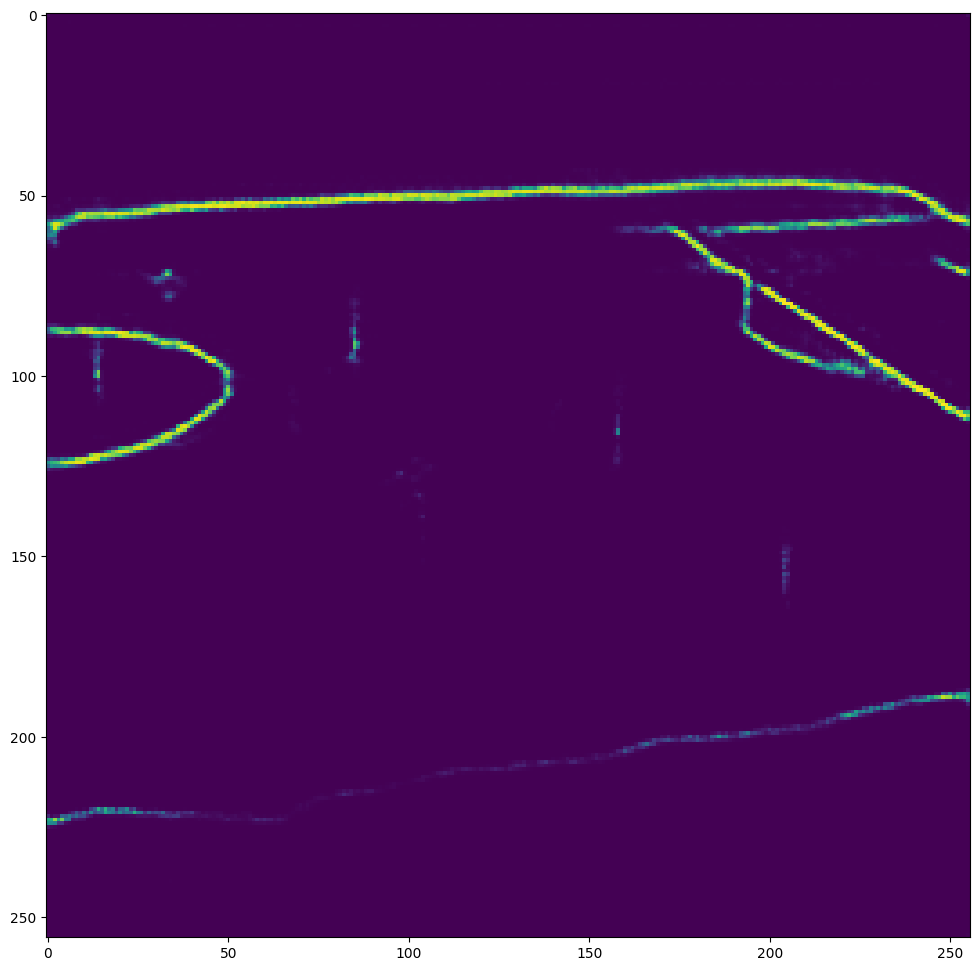

In [89]:
cap = cv2.VideoCapture("/content/e624c9_0.mp4")
counter = 0
para = None
para_ret = None
while(True):
    counter += 1
    ret, frame = cap.read()
    if frame is None:
        break
    if is_longview(frame, ssd_model):
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        w, h = img.size
        box = (int(w/2-h/2), 0, int(w/2+h/2), h)
        img = img.crop(box)
        transform = get_transform(opt)
        input_img = transform(img)
        input_img = {'A':input_img.unsqueeze(0), 'A_paths': ""}
        GAN_line_detection(input_img, counter)
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()


0001: process image... 


AttributeError: ignored